## ATAC + MULTIOME (males april 2021)

### Dimensionality reduction with cisTopic for single samples from cellatac

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


**r2py setup**

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)

**Load data**

In [7]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/males_apr2021/"
experiment_prefix = 'males_'

In [8]:
adata = sc.read_h5ad(outdir + experiment_prefix + '_ATAC_raw.h5ad')

In [10]:
adata.X

<31261x232562 sparse matrix of type '<class 'numpy.float32'>'
	with 166429558 stored elements in Compressed Sparse Row format>

**Setup of cisTopic**

In [11]:
# Remove empty rows
bool_matrix = adata.X.sum(0) > 0
bool_vector = np.squeeze(np.asarray(bool_matrix))
adata = adata[:, bool_vector]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
adata

View of AnnData object with n_obs × n_vars = 31261 × 232562
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Assess if there are cells with very low number of counts**

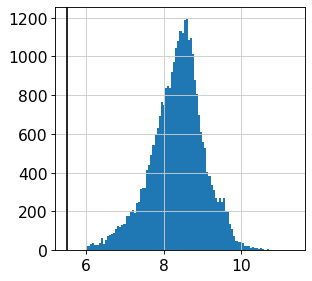

In [13]:
import matplotlib.pyplot as plt
plt.hist(adata.obs['log1p_total_counts'], bins=100);
plt.axvline(x=5.5, color="black")

**Convert anndata to SingleCellExperiment**

In [14]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 232562 31261 
metadata(0):
assays(2): X binary_raw
rownames(232562): chr1:816745-817435 chr1:817739-818227 ...
  chrY:22727855-22728985 chrY:26408688-26409702
rowData names(15): peak_width exon ... total_counts log1p_total_counts
colnames(31261): 01-AAACGAAAGCTGAGGT-1 01-AAACGAACAATCATCG-1 ...
  09-TTTGTGTTCGAAGTAG-1 09-TTTGTTGGTGAGCGAA-1
colData names(9): cellatac_clusters n_genes_by_counts ...
  pct_counts_in_top_200_genes pct_counts_in_top_500_genes
reducedDimNames(0):
altExpNames(0):


**Train cisTopic model**

In [14]:
%%R 

# Initialize cisTopic object 
cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

cisTopicObject

An object of class cisTopic in project ATAC_cisTopic 
 232562 regions across 31261 samples.


In [15]:
%%R -i outdir -i experiment_prefix

topics_vec <- c(20, 21, 22, 23, 24,25, 26, 27, 28, 29, 30)
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic = topics_vec, 
                                   seed = 1712, 
                                   nCores = 11, 
                                   iterations = 500
                                  )

## Save trained models
saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

[1] "Exporting data..."
[1] "Run models..."


In [9]:
%%R -i outdir -i experiment_prefix
cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

[1] "Are these CGS models? Please, use type=\"maximum\""


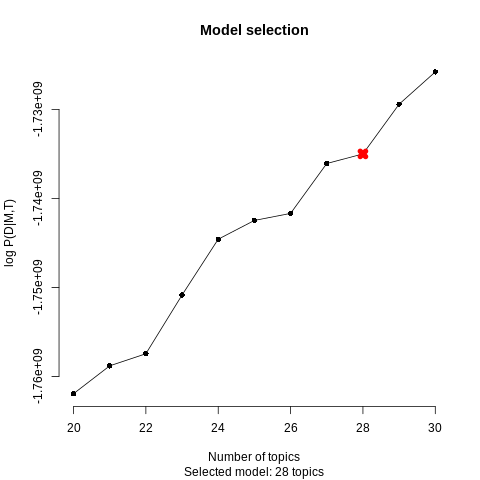

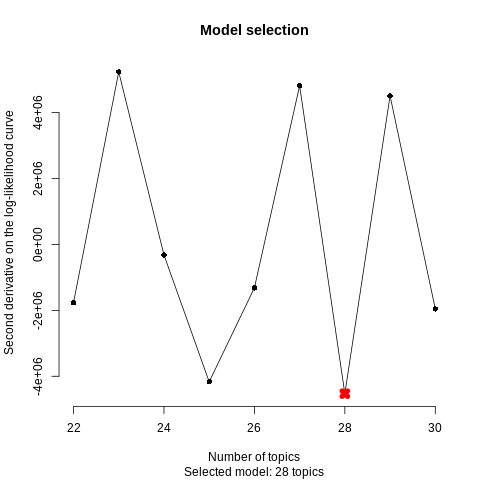

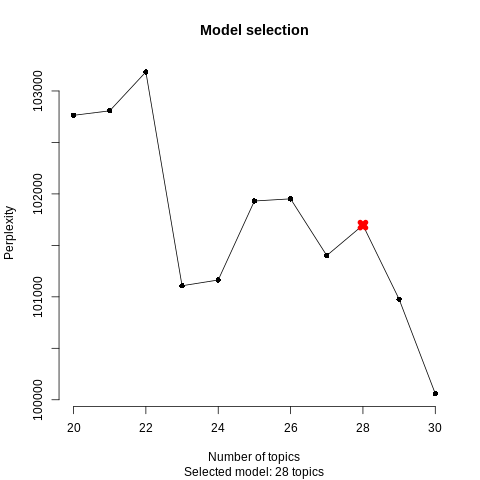

In [10]:
%%R

cistopic_model <- selectModel(cisTopicObject, select = 28)

In [17]:
%%R -o topicXcell

topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')
dim(topicXcell)

[1]    28 31261


In [18]:
topicXcell

array([[4.22502604e-03, 7.19981509e-03, 5.99785109e-02, ...,
        2.34662459e-01, 8.94361113e-03, 1.16816681e-02],
       [4.39865725e-04, 2.06864671e-03, 1.34744717e-02, ...,
        1.87822339e-03, 1.05879522e-03, 2.07213624e-04],
       [9.08091214e-02, 1.19750376e-01, 7.38389908e-02, ...,
        1.34908783e-01, 6.52282025e-02, 8.04442142e-02],
       ...,
       [2.72404213e-01, 2.37062291e-01, 8.81809861e-02, ...,
        1.67885459e-02, 1.43643218e-01, 9.79213883e-02],
       [1.49172358e-01, 8.89402519e-02, 1.06900394e-01, ...,
        4.03356170e-02, 6.80757199e-02, 6.27533510e-02],
       [3.32214377e-03, 2.53091413e-03, 4.12909388e-02, ...,
        1.35886383e-01, 5.71107724e-03, 1.06391245e-02]])

In [21]:
adata.obsm['X_cistopic_28'] = topicXcell.T

**Visualize dimensionality reduction results**

In [22]:
sc.pp.neighbors(adata, n_neighbors= 15, use_rep="X_cistopic_28")

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


In [23]:
sc.tl.umap(adata, min_dist = 0.4, spread = 1)

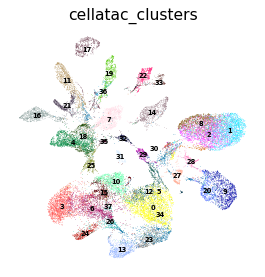

In [24]:
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color = "cellatac_clusters", frameon = False, size = 1, legend_loc = 'on data', legend_fontsize = 6)


In [25]:
adata

AnnData object with n_obs × n_vars = 31261 × 232562
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors'
    obsm: 'X_cistopic_28', 'X_umap'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

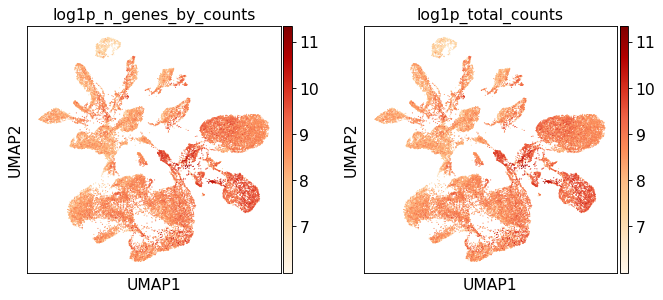

In [26]:
sc.pl.umap(adata, color = ['log1p_n_genes_by_counts', 'log1p_total_counts'], ncols = 2, color_map = "OrRd")

#### Add metadata for males

In [27]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

04    8513
07    5405
06    5335
05    4506
02    2866
09    1429
08    1379
01    1111
03     717
Name: code, dtype: int64

In [28]:
# Sample from code 
sample_dictionary = {'01' : 'FCA_GND8768481', '02' : 'FCA_GND8768482', '03' : 'FCA_GND8768487',
                    '04' : 'FCA_GND8795927', '05' : 'FCA_GND8795928', '06' : 'HD_F_GON9479872', 
                    '07' : 'FCA_GND9332157', '08' : 'HD_F_GON9525611', '09' : 'HD_F_GON9525612'}
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

FCA_GND8795927     8513
FCA_GND9332157     5405
HD_F_GON9479872    5335
FCA_GND8795928     4506
FCA_GND8768482     2866
HD_F_GON9525612    1429
HD_F_GON9525611    1379
FCA_GND8768481     1111
FCA_GND8768487      717
Name: sample, dtype: int64

In [29]:
sex_dictionary = {'FCA_GND8795927' : 'male',  
                 'FCA_GND8795928' : 'male', 'FCA_GND8768482' : 'male',  
                 'FCA_GND8768481' : 'male', 'FCA_GND8768487' : 'male', 
                 'HD_F_GON9479872' : 'male', 'HD_F_GON9525611' : 'male', 'HD_F_GON9525612' : 'male', 
                 'FCA_GND9332157' : 'male'}
adata.obs['sex'] = adata.obs['sample'].map(sex_dictionary)
adata.obs['sex'].value_counts(dropna = False)

male    31261
Name: sex, dtype: int64

In [30]:
stage_dictionary = { 'FCA_GND8795927' : '7 PCW', 
                   'FCA_GND8795928' : '12 PCW', 'FCA_GND8768482' : '11 PCW',  
                   'FCA_GND8768481' : '19 PCW', 'FCA_GND8768487' : '12 PCW', 
                 'HD_F_GON9479872' : '15 PCW', 'HD_F_GON9525611' : '12 PCW', 'HD_F_GON9525612' : '12 PCW', 
                   'FCA_GND9332157' : '17 PCW'}
adata.obs['stage'] = adata.obs['sample'].map(stage_dictionary)
adata.obs['stage'].value_counts(dropna = False)

7 PCW     8513
12 PCW    8031
17 PCW    5405
15 PCW    5335
11 PCW    2866
19 PCW    1111
Name: stage, dtype: int64

In [31]:
individual_dictionary = {'FCA_GND8795927' : 'Hrv17',  
                   'FCA_GND8795928' : 'Hrv18', 'FCA_GND8768482' : 'Hrv10',  
                   'FCA_GND8768481' : 'Hrv3', 'FCA_GND8768487' : 'Hrv15', 
                 'HD_F_GON9479872' : 'Hrv40', 'HD_F_GON9525611' : 'Hrv15', 'HD_F_GON9525612' : 'Hrv15', 
                        'FCA_GND9332157' : 'Hrv21'}
adata.obs['individual'] = adata.obs['sample'].map(individual_dictionary)
adata.obs['individual'].value_counts(dropna = False)

Hrv17    8513
Hrv21    5405
Hrv40    5335
Hrv18    4506
Hrv15    3525
Hrv10    2866
Hrv3     1111
Name: individual, dtype: int64

#### Plot metadata information

... storing 'code' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'individual' as categorical


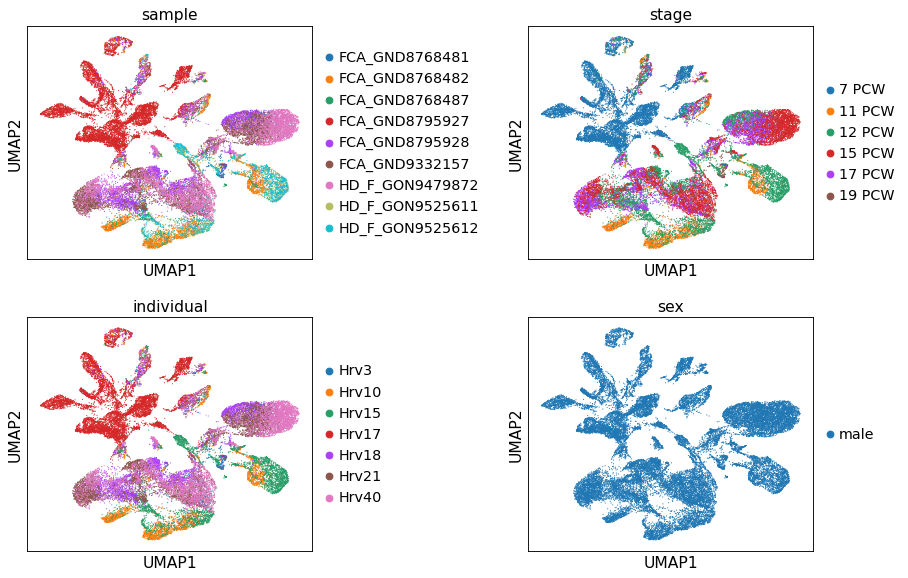

In [32]:
sc.pl.umap(adata, color = ['sample', 'stage', 'individual', 'sex'], ncols = 2, wspace = 0.6)

#### De-noising the peak x cell matrix with cisTopic

The learnt LDA model from cisTopic can be used to generate a de-noised accessibility matrix. From the paper:

cisTopic calculates the predictive distribution, which describes the probability of each region in each cell, by multiplying the topic–cell and the region–topic distributions:$$
P(r_i|c_j) = \sum_{k=1}^{K}{P(r_i|T_k)P(T_k|c_j)}
$$where

 * $P(r_i | c_j)$ is the probability of region i in cell j,
 * $P(r_i | T_k)$ is the probability of region i in topic k, and
 * $P(T_k | c_j)$ is the probability of topic k in cell j.

In [33]:
#%%R 

#install.packages("bigmemory")

In [11]:
%%R -o p_mat

library(bigmemory)
p_mat <- predictiveDistribution(cistopic_model, big.matrix=FALSE)

In [12]:
%%R
dim(p_mat)

[1] 232562  31261


In [13]:
p_mat

array([[6.18806371e-06, 6.41098660e-06, 4.89621429e-06, ...,
        1.61844788e-06, 5.47839076e-06, 4.71283382e-06],
       [2.09686645e-07, 2.57191725e-07, 2.49977741e-06, ...,
        1.02400309e-06, 2.55809093e-07, 2.94557968e-07],
       [5.71921728e-05, 5.29357019e-05, 3.78487894e-05, ...,
        2.78919628e-05, 4.16449070e-05, 3.69463594e-05],
       ...,
       [7.24084028e-05, 6.51905938e-05, 5.26922782e-05, ...,
        4.74267155e-05, 4.45012066e-05, 4.21375654e-05],
       [8.04404320e-06, 8.42464113e-06, 5.07798931e-06, ...,
        1.86720587e-06, 1.73147913e-05, 1.60102456e-05],
       [3.13771933e-07, 3.80131152e-07, 2.56004888e-06, ...,
        2.60390111e-07, 2.85436795e-07, 3.51926092e-07]])

#### Important: 

cistopic_p is a numpy array (cannot convert to sparse matrix because it crashes), and it is too large to save --> will save it in a separate object

In [37]:
adata.layers["cistopic_p"] = p_mat.T

#### Calculate de-noised gene scores

The de-noised accessibility signal can be used to calculate a gene-level accessibility scores (first implemented in Bravo Gonzales-Blas et al. 2020). This is very useful to check out accessibility of marker genes for example. From the paper:

we first multiply the region‐topic and topic‐cell distributions to obtain a region‐cell distribution, which indicates the probability of accessibility of each region in each cell. Then, for each gene, we aggregate the probabilities of the surrounding regions (in this case, 5 kb around the TSS plus introns), resulting in a gene activity score

At the moment there is no specific function in cisTopic to do this, but here is a simple implementation using functionality in GenomicRanges and Signac. Here I use peaks within a 5kb window of a gene (d parameter)

In [38]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
# library(Signac)

In [39]:
%%R

StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

In [40]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(assay(adata, "X")), sep=c(":", "-"))

In [41]:
%%R -o adj_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=5000)

# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
adj_mat <- t(adj_mat[,keep.genes])

In [42]:
%%R -o gene_var
head(rownames(adj_mat))
genes <- rownames(adj_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

In [43]:
gene_mat = adj_mat.dot(p_mat)

Save another anndata object with the same .obs as the original one, but storing the gene score info.

In [44]:
%%R -i gene_mat -o predMatSumByGene

# Multiply and round predictive matrix to be able to integrate with scRNAseq data
predMatSumByGene <- round(gene_mat * 1000000)

In [45]:
gene_var = gene_var.set_index("gene_name")
gene_var.head()

gene_id
gene_name                    
RP5-857K21.4  ENSG00000230021
FAM41C        ENSG00000230368
TUBB8P11      ENSG00000234711
FAM166AP3     ENSG00000283040
RP11-54O7.16  ENSG00000272438

In [46]:
predMatSumByGene = predMatSumByGene.T
predMatSumByGene.shape

(31261, 22236)

In [47]:
gene_adata = anndata.AnnData(X=predMatSumByGene, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 31261 × 22236
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'

In [48]:
gene_adata.var_names_make_unique()

In [49]:
# Add cisTopic dimensionality reduction to match visualization 
gene_adata.obsm['X_cistopic_28'] = topicXcell.T

In [50]:
adata

AnnData object with n_obs × n_vars = 31261 × 232562
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_28', 'X_umap'
    layers: 'binary_raw', 'cistopic_p'
    obsp: 'distances', 'connectivities'

In [51]:
del adata.layers['cistopic_p']

In [52]:
adata

AnnData object with n_obs × n_vars = 31261 × 232562
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'sample_colors', 'stage_colors', 'individual_colors', 'sex_colors'
    obsm: 'X_cistopic_28', 'X_umap'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

**Save anndata objects**

In [53]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [54]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

**Proceed with gene_data to look at marker genes**

In [55]:
gene_adata

AnnData object with n_obs × n_vars = 31261 × 22236
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'
    obsm: 'X_cistopic_28'

In [56]:
sc.pp.neighbors(gene_adata, n_neighbors=15, use_rep="X_cistopic_28")

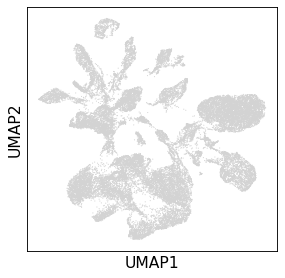

In [57]:
sc.tl.umap(gene_adata, min_dist = 0.4, spread = 1)
sc.pl.umap(gene_adata)

**Plot markers per cell type from RNA-seq**

In [58]:
mesothelial = ['LRRN4', 'UPK3B', 'KLK11'] 
gonad_somatic_cells = ['NR5A1', 'AMHR2', 'MIR202HG'] 
supporting = ['WNT6', 'WIPF3']
supporting_LGR5 = ['LGR5']
supporting_PAX8 = ['PAX8']
preGranulosa_lineage = ["KITLG",  'RSPO1', 'OSR1' , 'NR4A1']
granulosa_lineage = ['FOXL2', 'IRX3', 'CYP19A1', 'RDH10']
sertoli_lineage = ['SOX9', 'INHBB', 'AMH', 'CLDN11', 'INHA', 'TFF3', 'DKK3']
mesenchymal_steroidogenic = ['CYP11A1', 'CYP17A1', 'STAR',  'MGARP', 'FDXR']
leydigFetal_lineage = ['FDX1'] # Not there
leydig_lineage = ['INSL3', 'GLI1', 'HHIP', 'PTCH2']
preTheca_lineage = ['KIT', 'LHCGR'] # Not there
mesenchymal = ['DCN', 'PDGFRA','TCF21', 'OGN', 'POSTN']
gonadal_mesenchymal = ['LHX9', 'GATA4']
ovary_stroma = ['SPRR2F', 'AKR1C1', 'DIRAS3'] # Not there
testis_border_mesenhyme = ['IGF1', 'FGL2', 'PCSK2', 'ANGPTL1']
testis_myoid= ['PTCH1', 'NGFR', 'MSC', 'NEFL']
extragonadal_mesen = ['GATA2', 'NR2F1', 'WNT4', 'RSPO3', 'MEIS1', 'FAP']
mesoneprhic_stroma = ['CRABP1', 'ALX1',  'FOXD1']
gonad_dev = ['EMX2', 'WT1']
muscoskeletal = ['MYF5','PAX7','MYF6', 'MYLPF']
epithelial = ["EPCAM"]
PGCs= ['POU5F1', 'NANOG', 'NANOS3']
GCs = ['DAZL', 'DDX4']
immunePGCs= ['PTPRC']
endothelial = ['PECAM1', 'VWF', 'CDH5']
erythroid = ["GYPC", "HBA1"]
neural = ['ASCL1', 'ELAVL4']
PV = ["PDGFRB", 'ACTA2']
cycling = ['CDK1', 'MKI67'] # Not there
quiescent = ['CDKN1B']
male = ['SRY', 'RPS4Y1','DDX3Y'] # Not there

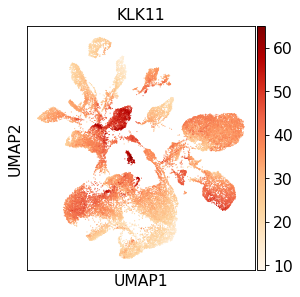

In [59]:
# Mesothelial
sc.pl.umap(gene_adata, color = ['KLK11'], ncols = 3, color_map = 'OrRd')

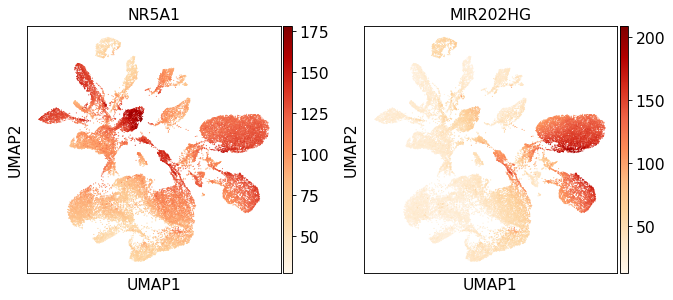

In [60]:
# Gonadal somatic
sc.pl.umap(gene_adata, color = ['NR5A1',  'MIR202HG'] , ncols = 3, color_map = 'OrRd')

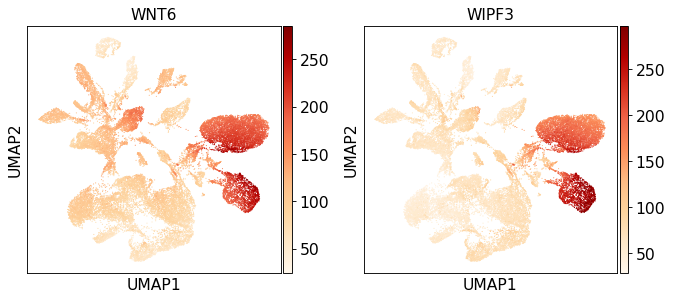

In [61]:
sc.pl.umap(gene_adata, color = supporting, ncols = 3, color_map = 'OrRd')

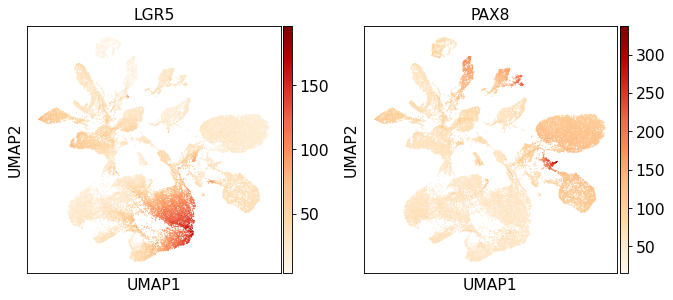

In [62]:
sc.pl.umap(gene_adata, color = ['LGR5', 'PAX8'], ncols = 3, color_map = 'OrRd')

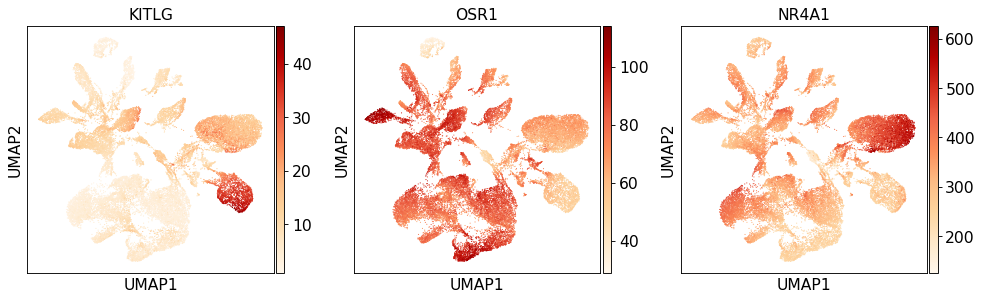

In [63]:
# Pregranulosa
sc.pl.umap(gene_adata, color = ["KITLG", 'OSR1' , 'NR4A1'], ncols = 3, color_map = 'OrRd')

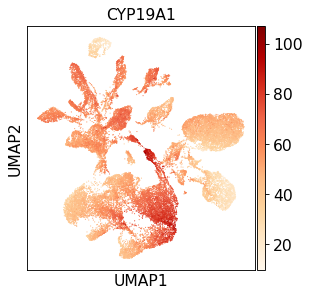

In [64]:
# Granulosa 
sc.pl.umap(gene_adata, color = ['CYP19A1'], ncols = 2, color_map = 'OrRd')

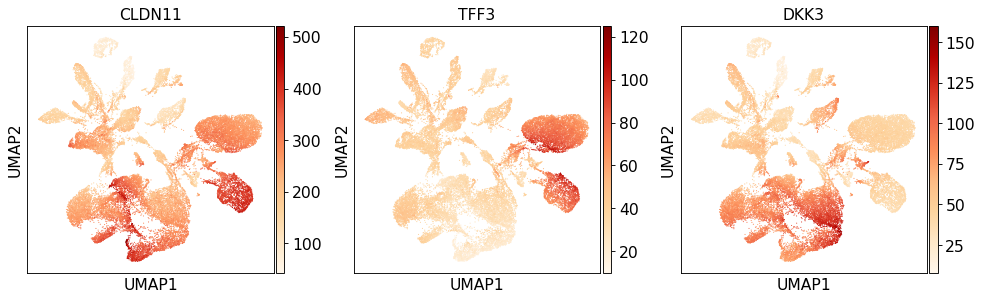

In [65]:
# Sertoli lineage
sc.pl.umap(gene_adata, color = [ 'CLDN11', 'TFF3', 'DKK3'], ncols = 3, color_map = 'OrRd')

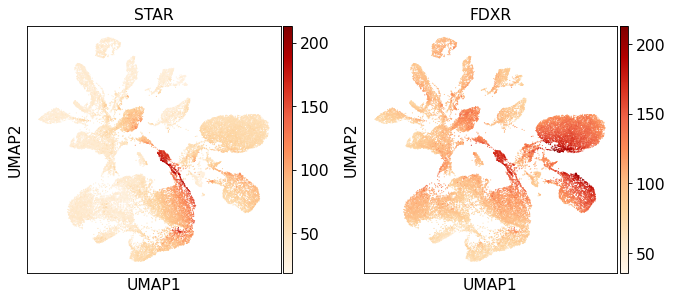

In [66]:
# Steroidogenic mesenchymal 
sc.pl.umap(gene_adata, color = ['STAR',  'FDXR'], ncols = 3, color_map = 'OrRd')

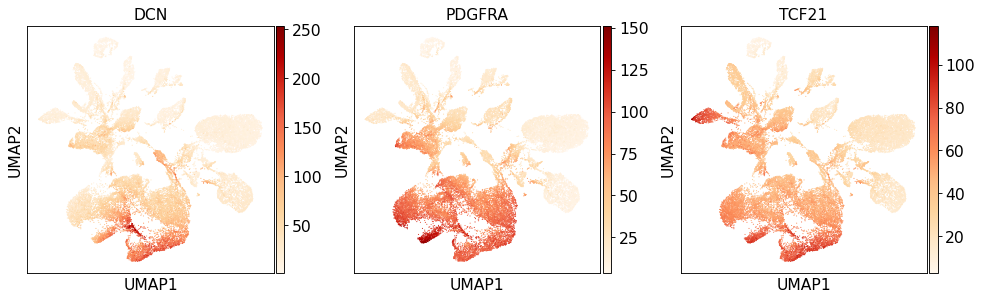

In [67]:
# Mesenchymal 
sc.pl.umap(gene_adata, color = ['DCN', 'PDGFRA','TCF21'], ncols = 3, color_map = 'OrRd')

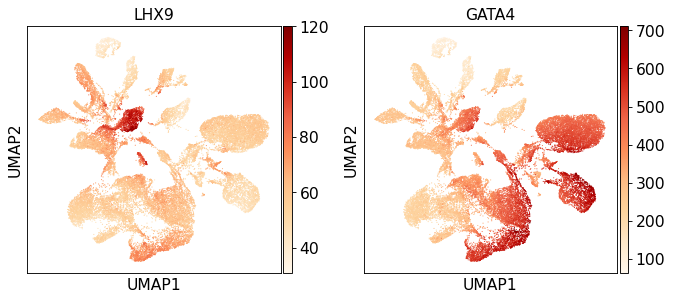

In [68]:
# Gonadal mesenchymal 
sc.pl.umap(gene_adata, color = ['LHX9', 'GATA4'], ncols = 3, color_map = 'OrRd')

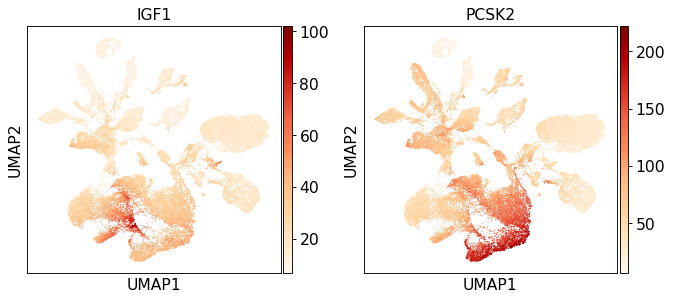

In [69]:
# Testis border mesenchyme
sc.pl.umap(gene_adata, color = ['IGF1', 'PCSK2'], ncols = 3, color_map = 'OrRd')

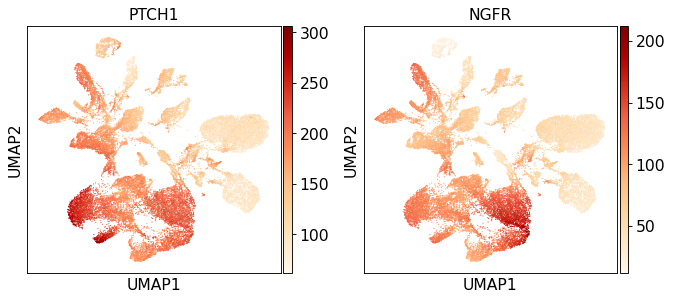

In [70]:
# Testis myoid
sc.pl.umap(gene_adata, color = ['PTCH1', 'NGFR'], ncols = 3, color_map = 'OrRd')

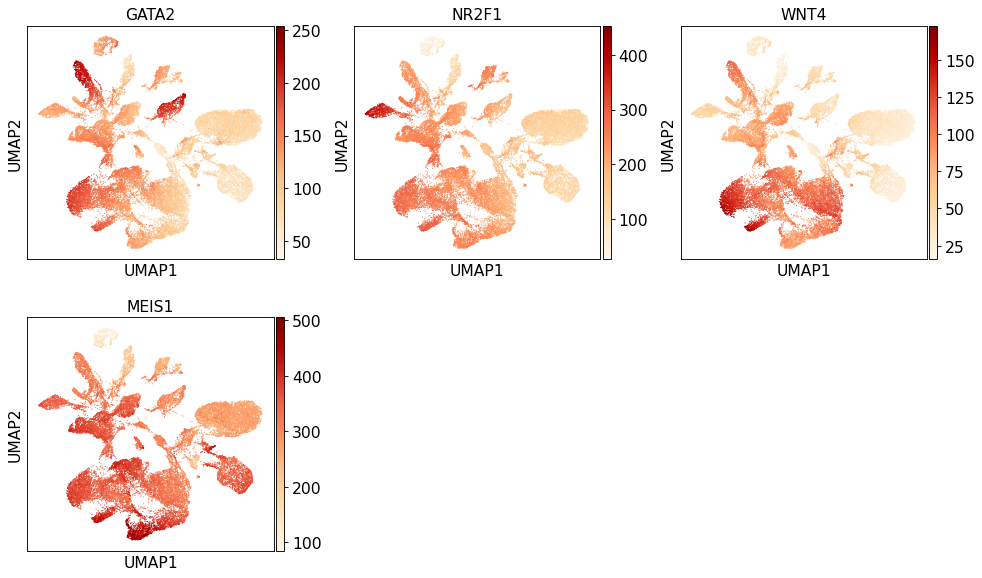

In [71]:
# Extragonal mesenchymal 
sc.pl.umap(gene_adata, color = ['GATA2', 'NR2F1', 'WNT4',  'MEIS1'], ncols = 3, color_map = 'OrRd')

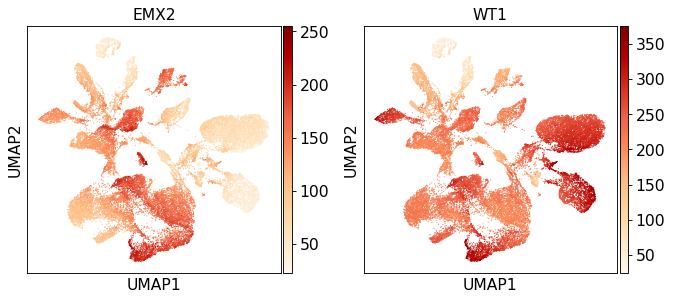

In [72]:
# Gonad dev
sc.pl.umap(gene_adata, color = ['EMX2', 'WT1'], ncols = 3, color_map = 'OrRd')

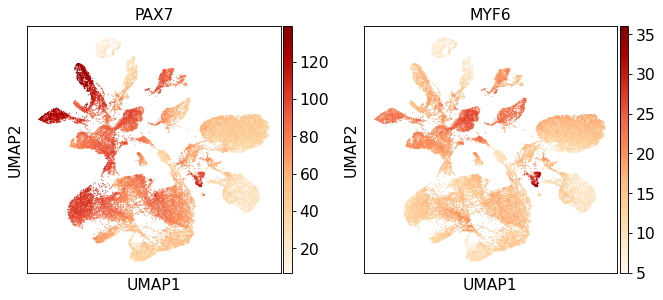

In [73]:
# Muscoskeletal 
sc.pl.umap(gene_adata, color = ['PAX7','MYF6'], ncols = 3, color_map = 'OrRd')

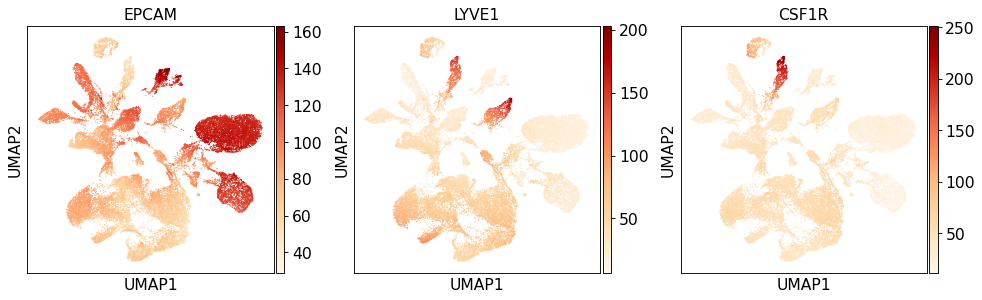

In [74]:
# Epithelial and immune
sc.pl.umap(gene_adata, color = [ 'EPCAM',  'LYVE1', 'CSF1R' 
                                                           ], ncols = 3, color_map = 'OrRd')

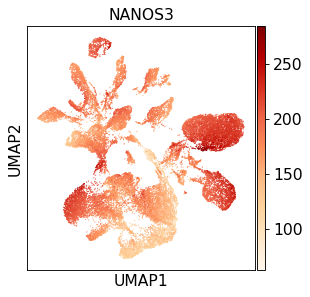

In [75]:
# PGC
sc.pl.umap(gene_adata, color = [ 'NANOS3'], ncols = 3, color_map = 'OrRd')

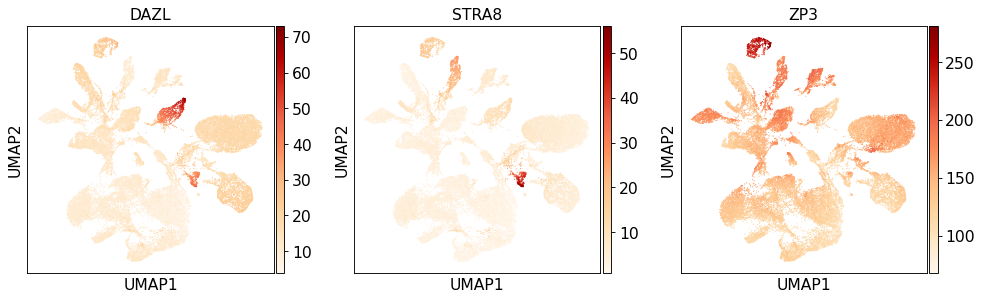

In [76]:
# Germ cells
sc.pl.umap(gene_adata, color = ['DAZL',  'STRA8', 'ZP3'], ncols = 3, color_map = 'OrRd')

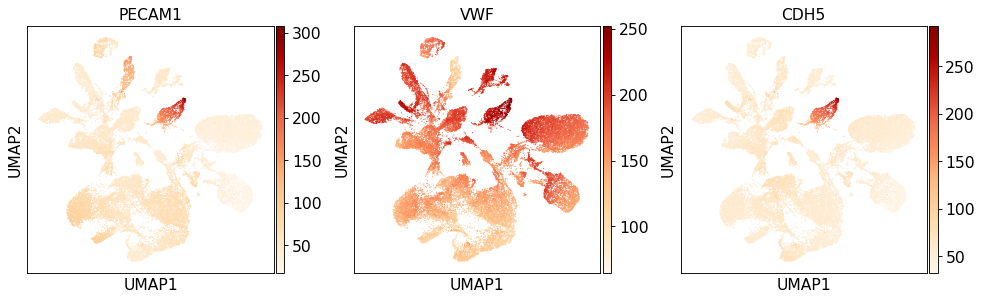

In [77]:
# Endothelial
sc.pl.umap(gene_adata, color = ['PECAM1', 'VWF', 'CDH5'], ncols = 3, color_map = 'OrRd')

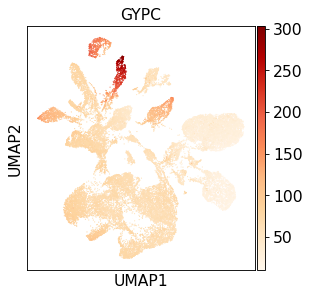

In [78]:
# Erythroid
sc.pl.umap(gene_adata, color = ["GYPC"], ncols = 3, color_map = 'OrRd')

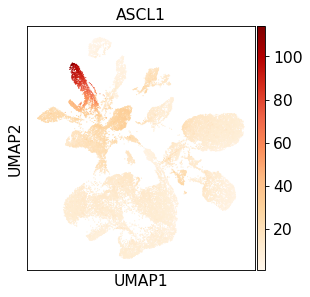

In [79]:
# Neural
sc.pl.umap(gene_adata, color = ['ASCL1'], ncols = 3, color_map = 'OrRd')

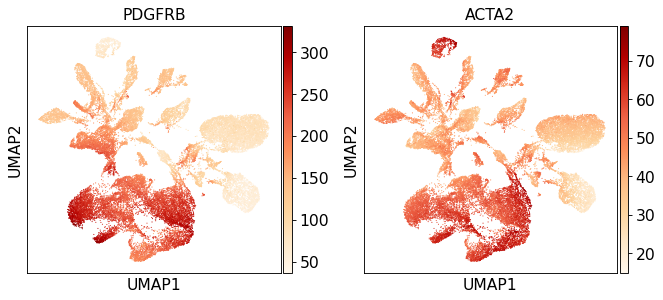

In [80]:
# Perivascular
sc.pl.umap(gene_adata, color = ["PDGFRB", 'ACTA2'], ncols = 3, color_map = 'OrRd')

In [81]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

## Compute CCANs enriched in each cell type

In [14]:
p_mat_transpose = p_mat.T 

In [15]:
ccans = pd.read_csv(outdir + experiment_prefix + "_ccans_annotated.csv", index_col = 0)
ccans = pd.DataFrame(ccans)
ccans.head()

Peak  CCAN           peaks_formatted  peak_width  exon  \
1  chr1-100048203-100049071     2  chr1-100048203-100049071         869     0   
2  chr1-100127012-100127809     2  chr1-100127012-100127809         798     0   
3    chr1-10012751-10013239   757    chr1-10012751-10013239         489     0   
4      chr1-1001625-1002088   787      chr1-1001625-1002088         464     0   
5  chr1-100249062-100250323     2  chr1-100249062-100250323        1262     1   

           gene_id  gene gene_name annotation  promoter  tss_distance  \
1  ENSG00000156875     1   MFSD14A     intron         0          9599   
2  ENSG00000156876     1     SASS6     intron         0          5145   
3  ENSG00000162444     1      RBP7     intron         0         15534   
4  ENSG00000187608     1     ISG15   promoter         1           479   
5  ENSG00000137992     1       DBT       exon         1             0   

   ENCODE_blacklist  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0

In [16]:
ccans.shape

(79838, 12)

Workflow: 

 * Subset the cells x peaks matrix to keep only the peaks in CCANs
 * Create a new matrix: cell_type x CCANs 
 * Normalize new matrix by CCAN

In [17]:
peaksinCCANs = list(ccans['Peak'])

In [18]:
adata.var['peaks_formatted'] = [i.replace(":", "-") for i in adata.var_names]
cistopic = pd.DataFrame(p_mat_transpose, index=adata.obs_names, columns=adata.var['peaks_formatted'])
cistopic.head()

peaks_formatted        chr1-816745-817435  chr1-817739-818227  \
01-AAACGAAAGCTGAGGT-1            0.000006        2.096866e-07   
01-AAACGAACAATCATCG-1            0.000006        2.571917e-07   
01-AAACGAACATGCACTA-1            0.000005        2.499777e-06   
01-AAACTCGTCACCCGGA-1            0.000006        3.808550e-07   
01-AAACTGCCAAGGGTAC-1            0.000002        2.103756e-07   

peaks_formatted        chr1-826603-827799  chr1-842634-843206  \
01-AAACGAAAGCTGAGGT-1            0.000057        5.795896e-07   
01-AAACGAACAATCATCG-1            0.000053        4.653109e-07   
01-AAACGAACATGCACTA-1            0.000038        1.390728e-06   
01-AAACTCGTCACCCGGA-1            0.000052        5.686688e-07   
01-AAACTGCCAAGGGTAC-1            0.000039        7.054901e-07   

peaks_formatted        chr1-868834-869156  chr1-869371-870182  \
01-AAACGAAAGCTGAGGT-1            0.000006            0.000029   
01-AAACGAACAATCATCG-1            0.000006            0.000024   
01-AAACGAACATGCACTA-1            0.000003            0.000020   
01-AAACTCGTCACCCGGA-1            0.000006            0.000026   
01-AAACTGCCAAGGGTAC-1            0.000001            0.000017   

peaks_formatted        chr1-875170-875880  chr1-876307-877282  \
01-AAACGAAAGCTGAGGT-1            0.000006            0.000009   
01-AAACGAACAATCATCG-1            0.000005            0.000008   
01-AAACGAACATGCACTA-1            0.000004            0.000008   
01-AAACTCGTCACCCGGA-1            0.000006            0.000008   
01-AAACTGCCAAGGGTAC-1            0.000004            0.000009   

peaks_formatted        chr1-901220-901648  chr1-906722-907063  ...  \
01-AAACGAAAGCTGAGGT-1            0.000008            0.000002  ...   
01-AAACGAACAATCATCG-1            0.000007            0.000002  ...   
01-AAACGAACATGCACTA-1            0.000004            0.000002  ...   
01-AAACTCGTCACCCGGA-1            0.000007            0.000002  ...   
01-AAACTGCCAAGGGTAC-1            0.000001            0.000004  ...   

peaks_formatted        chrY-19541479-19541978  chrY-19566682-19568061  \
01-AAACGAAAGCTGAGGT-1            3.440326e-08                0.000074   
01-AAACGAACAATCATCG-1            4.716023e-08                0.000067   
01-AAACGAACATGCACTA-1            1.277897e-06                0.000052   
01-AAACTCGTCACCCGGA-1            1.179621e-07                0.000064   
01-AAACTGCCAAGGGTAC-1            1.616299e-07                0.000063   

peaks_formatted        chrY-19572639-19573139  chrY-19578132-19578969  \
01-AAACGAAAGCTGAGGT-1            5.885745e-06            1.461460e-06   
01-AAACGAACAATCATCG-1            5.342432e-06            1.403379e-06   
01-AAACGAACATGCACTA-1            3.702364e-06            1.378102e-06   
01-AAACTCGTCACCCGGA-1            5.602289e-06            1.565521e-06   
01-AAACTGCCAAGGGTAC-1            5.573299e-07            4.168543e-07   

peaks_formatted        chrY-19743350-19743623  chrY-19743945-19745305  \
01-AAACGAAAGCTGAGGT-1            1.265024e-06                0.000038   
01-AAACGAACAATCATCG-1            1.693239e-06                0.000032   
01-AAACGAACATGCACTA-1            1.004766e-06                0.000027   
01-AAACTCGTCACCCGGA-1            1.439614e-06                0.000032   
01-AAACTGCCAAGGGTAC-1            9.103266e-07                0.000028   

peaks_formatted        chrY-20559702-20560811  chrY-20574996-20576260  \
01-AAACGAAAGCTGAGGT-1            9.815958e-07                0.000072   
01-AAACGAACAATCATCG-1            1.197738e-06                0.000065   
01-AAACGAACATGCACTA-1            2.285163e-06                0.000053   
01-AAACTCGTCACCCGGA-1            1.097603e-06                0.000065   
01-AAACTGCCAAGGGTAC-1            1.982594e-06                0.000060   

peaks_formatted        chrY-22727855-22728985  chrY-26408688-26409702  
01-AAACGAAAGCTGAGGT-1                0.000008            3.137719e-07  
01-AAACGAACAATCATCG-1                0.000008            3.801312e-07  
01-AAACGAACATGCACTA-1                0.0000

In [19]:
'LHX9' in list(adata.var['gene_name'])

True

In [20]:
cells_peaksinCCANs = cistopic.loc[:, peaksinCCANs]
cells_peaksinCCANs.shape

(31261, 79838)

#### Import cell type annotations and add them 

In [21]:
annots = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
#annots = annots[[i in [ 'FetalLeydig', 'Ti', 'Gi', 'M_MGP', 'M_prog_ISL1'] 
#                for i in annots.obs['cell_type']]]
barcodes = list(annots.obs_names)
cells_peaksinCCANs = cells_peaksinCCANs.loc[barcodes, :]

In [22]:
cells_peaksinCCANs.shape

(30276, 79838)

In [23]:
# Mapping of cells to cell types 
annots.obs['barcode'] = annots.obs_names
cells_celltypes = annots.obs[['barcode', 'cell_type']]
cells_celltypes.head()

barcode cell_type
01-AAACGAAAGCTGAGGT-1  01-AAACGAAAGCTGAGGT-1   Sertoli
01-AAACGAACAATCATCG-1  01-AAACGAACAATCATCG-1   Sertoli
01-AAACTCGTCACCCGGA-1  01-AAACTCGTCACCCGGA-1   Sertoli
01-AAACTGCCAAGGGTAC-1  01-AAACTGCCAAGGGTAC-1     sPAX8
01-AAACTGCGTGAATGTA-1  01-AAACTGCGTGAATGTA-1     M_MGP

In [24]:
cells_mapping = cells_celltypes.groupby('cell_type').groups

In [25]:
# Mean by rows 
for key in cells_mapping: 
    print(key)
    cells_peaksinCCANs.loc[key] = cells_peaksinCCANs.loc[cells_mapping[key]].mean(axis = 0)

Germ cells
coelEpi
sPAX8
Sertoli
FetalLeydig
Ti
Gi
PV
M_MGP
M_prog_ISL1
Epithelial
Immune
Endothelial
Erythroid
Neural


In [26]:
cells_peaksinCCANs.tail()

peaks_formatted  chr1-100048203-100049071  chr1-100127012-100127809  \
Epithelial                       0.000002                  0.000002   
Immune                           0.000003                  0.000002   
Endothelial                      0.000002                  0.000002   
Erythroid                        0.000006                  0.000002   
Neural                           0.000002                  0.000002   

peaks_formatted  chr1-10012751-10013239  chr1-1001625-1002088  \
Epithelial                 1.586324e-06              0.000037   
Immune                     7.390685e-07              0.000030   
Endothelial                1.244248e-06              0.000031   
Erythroid                  5.548286e-07              0.000024   
Neural                     3.474407e-06              0.000033   

peaks_formatted  chr1-100249062-100250323  chr1-100265466-100266895  \
Epithelial                       0.000082                  0.000060   
Immune                           0.000073                  0.000071   
Endothelial                      0.000078                  0.000060   
Erythroid                        0.000136                  0.000114   
Neural                           0.000072                  0.000057   

peaks_formatted  chr1-10031508-10031801  chr1-100354903-100355232  \
Epithelial                     0.000007                  0.000013   
Immune                         0.000002                  0.000002   
Endothelial                    0.000002                  0.000003   
Erythroid                      0.000001                  0.000002   
Neural                         0.000005                  0.000004   

peaks_formatted  chr1-100364322-100365268  chr1-10043555-10044178  ...  \
Epithelial                   5.539773e-06                0.000002  ...   
Immune                       1.323594e-06                0.000001  ...   
Endothelial                  1.889304e-06                0.000002  ...   
Erythroid                    9.541700e-07                0.000001  ...   
Neural                       2.925860e-06                0.000002  ...   

peaks_formatted  chrY-12740970-12741756  chrY-12800286-12801282  \
Epithelial                 9.627885e-07                0.000002   
Immune                     7.816656e-07                0.000002   
Endothelial                1.138722e-06                0.000002   
Erythroid                  6.930418e-07                0.000002   
Neural                     1.039797e-06                0.000002   

peaks_formatted  chrY-12808884-12809373  chrY-13000240-13001174  \
Epithelial                 1.512105e-06            9.433825e-07   
Immune                     7.930767e-07            6.192340e-07   
Endothelial                9.039559e-07            8.865171e-07   
Erythroid                  6.731951e-07            5.608812e-07   
Neural                     1.194242e-06            1.288946e-06   

peaks_formatted  chrY-13210666-13211869  chrY-13442645-13443616  \
Epithelial                     0.000004                0.000002   
Immune                         0.000003                0.000008   
Endothelial                    0.000004                0.000001   
Erythroid                      0.000002                0.000005   
Neural                         0.000004                0.000001   

peaks_formatted  chrY-13543870-13544866  chrY-13551191-13551686  \
Epithelial                 4.195331e-07            3.915567e-07   
Immune                     1.883589e-06            6.787402e-06   
Endothelial                4.664390e-07            3.784708e-07   
Erythroid                  1.387465e-06            4.434040e-06   
Neural                     3.592201e-07            4.915085e-07   

peaks_formatted  chrY-13869314-13869995  chrY-13871424-13871730  
Epithelial                 1.037764e-06            5.396067e-07  
Immune                     1.551312e-06            5.831398e-06  
Endothelial                6.919430e-07            2.123846e-07  
Erythroid          

In [27]:
rows_celltypes = list(np.unique(cells_celltypes['cell_type']))
print(rows_celltypes)
# Select only aggregated rows
cells_peaksinCCANs = cells_peaksinCCANs.loc[rows_celltypes, ]

['Endothelial', 'Epithelial', 'Erythroid', 'FetalLeydig', 'Germ cells', 'Gi', 'Immune', 'M_MGP', 'M_prog_ISL1', 'Neural', 'PV', 'Sertoli', 'Ti', 'coelEpi', 'sPAX8']


In [28]:
cells_peaksinCCANs

peaks_formatted  chr1-100048203-100049071  chr1-100127012-100127809  \
Endothelial                      0.000002                  0.000002   
Epithelial                       0.000002                  0.000002   
Erythroid                        0.000006                  0.000002   
FetalLeydig                      0.000003                  0.000004   
Germ cells                       0.000005                  0.000005   
Gi                               0.000001                  0.000002   
Immune                           0.000003                  0.000002   
M_MGP                            0.000001                  0.000002   
M_prog_ISL1                      0.000002                  0.000002   
Neural                           0.000002                  0.000002   
PV                               0.000002                  0.000002   
Sertoli                          0.000009                  0.000016   
Ti                               0.000001                  0.000002   
coelEpi                          0.000003                  0.000003   
sPAX8                            0.000004                  0.000006   

peaks_formatted  chr1-10012751-10013239  chr1-1001625-1002088  \
Endothelial                1.244248e-06              0.000031   
Epithelial                 1.586324e-06              0.000037   
Erythroid                  5.548286e-07              0.000024   
FetalLeydig                1.012192e-06              0.000026   
Germ cells                 1.485651e-06              0.000029   
Gi                         7.909064e-07              0.000035   
Immune                     7.390685e-07              0.000030   
M_MGP                      7.692766e-07              0.000039   
M_prog_ISL1                1.305037e-06              0.000034   
Neural                     3.474407e-06              0.000033   
PV                         1.346529e-06              0.000042   
Sertoli                    4.958450e-06              0.000029   
Ti                         6.734775e-07              0.000035   
coelEpi                    1.014103e-06              0.000032   
sPAX8                      3.090204e-06              0.000030   

peaks_formatted  chr1-100249062-100250323  chr1-100265466-100266895  \
Endothelial                      0.000078                  0.000060   
Epithelial                       0.000082                  0.000060   
Erythroid                        0.000136                  0.000114   
FetalLeydig                      0.000064                  0.000052   
Germ cells                       0.000065                  0.000052   
Gi                               0.000076                  0.000050   
Immune                           0.000073                  0.000071   
M_MGP                            0.000081                  0.000057   
M_prog_ISL1                      0.000077                  0.000056   
Neural                           0.000072                  0.000057   
PV                               0.000086                  0.000067   
Sertoli                          0.000072                  0.000052   
Ti                               0.000067                  0.000052   
coelEpi                          0.000082                  0.000065   
sPAX8                            0.000065                  0.000051   

peaks_formatted  chr1-10031508-10031801  chr1-100354903-100355232  \
Endothelial                    0.000002                  0.000003   
Epithelial                     0.000007                  0.000013   
Erythroid                      0.000001                  0.000002   
FetalLeydig                    0.000003                  0.000006   
Germ cells                     0.000003                  0.000003   
Gi                             0.000002                  0.000002   
Immune                         0.000002                  0.000002   
M_MGP                          0.000002                  0.000002   
M_prog_ISL1                    0.000008                  0.00000

In [29]:
# Mapping of peaks to CCANs 
ccans = ccans.set_index('peaks_formatted')
peaks_ccans = ccans[['Peak', 'CCAN']]
peaks_mapping = peaks_ccans.groupby('CCAN').groups

In [30]:
# Mean by columns 
for key in peaks_mapping: 
    #print(key)
    cells_peaksinCCANs[key] = cells_peaksinCCANs[peaks_mapping[key]].mean(axis = 1)

In [31]:
cells_peaksinCCANs.shape

(15, 84207)

In [32]:
cols_ccans = list(np.unique(peaks_ccans['CCAN']))
# Select only aggregated rows and columns 
celltype_CCANs = cells_peaksinCCANs.loc[:, cols_ccans]

In [33]:
celltype_CCANs = celltype_CCANs.loc[(celltype_CCANs.sum(axis=1) != 0), (celltype_CCANs.sum(axis=0) != 0)]

In [34]:
celltype_CCANs.shape

(15, 4369)

In [35]:
# Normalize by column (CCAN)
from scipy.stats import zscore
celltype_CCANs_zscore = celltype_CCANs.apply(zscore)

In [36]:
celltype_CCANs_zscore

peaks_formatted      2         3         6         8         9         10    \
Endothelial      0.254581 -0.310740 -0.527837  3.650676 -0.967425 -0.573865   
Epithelial       0.179774 -0.700647 -0.513319  0.084798  0.308305 -0.250400   
Erythroid        2.851101 -0.835968  0.227973  0.075711 -1.315564 -0.903236   
FetalLeydig      0.150450 -0.291924  3.246307 -0.157194  1.100082 -0.299947   
Germ cells      -0.760944 -0.560550  0.198387 -0.272300 -0.515394 -0.474312   
Gi              -0.914593  0.865782 -0.652038 -0.601544  0.756005  1.445355   
Immune          -0.310463 -0.547203  0.791523  0.030128 -0.972560 -0.677459   
M_MGP           -0.990060  1.174865 -0.653165 -0.525781  0.394308  0.103305   
M_prog_ISL1     -0.595456  0.236542 -0.567737 -0.334725  2.824680 -0.010654   
Neural          -0.605340 -0.431633 -0.562694 -0.379835 -0.681292 -0.460713   
PV              -0.314524  0.480009 -0.559470 -0.311193 -0.445587  0.105684   
Sertoli          1.592100 -0.828187  0.854896 -0.180310 -0.349061 -0.671567   
Ti              -0.907646  2.991830 -0.580925 -0.667849 -0.486119  3.179685   
coelEpi          0.108141 -0.664846 -0.554858 -0.258186  0.054762 -0.291894   
sPAX8            0.262879 -0.577331 -0.147043 -0.152396  0.294860 -0.219981   

peaks_formatted      11        13        14        16    ...      9689  \
Endothelial     -0.645560 -0.791349 -0.366209 -0.634823  ... -0.010951   
Epithelial      -0.478312 -0.548000 -0.488869 -0.575663  ... -0.056070   
Erythroid       -1.016427 -1.077983 -0.741756 -0.925924  ...  3.193471   
FetalLeydig     -0.436402  0.941917  0.893774 -0.548525  ... -1.036004   
Germ cells      -0.670395 -0.466507  0.099787 -0.687903  ... -1.116886   
Gi               0.857001 -0.037901 -0.577539  2.214109  ... -0.418913   
Immune          -0.720052 -0.791476 -0.656571 -0.646740  ...  0.584697   
M_MGP            0.059148 -0.479776 -0.692139  0.585626  ... -0.098963   
M_prog_ISL1      1.397088  2.661412 -0.085965  2.381728  ...  0.013268   
Neural           0.185677 -0.608613 -0.294784 -0.587995  ... -0.331598   
PV               0.061348 -0.392645 -0.475892 -0.240197  ...  0.559843   
Sertoli         -0.749202  0.601714  3.102921 -0.633835  ... -0.304083   
Ti               2.915224  1.635370 -0.585419  0.500876  ... -0.626794   
coelEpi         -0.171035 -0.541680 -0.388875  0.232684  ...  0.524521   
sPAX8           -0.588102 -0.104484  1.257535 -0.433417  ... -0.875538   

peaks_formatted      9690      9692      9697      9704      9705      9706  \
Endothelial     -0.522974 -0.434677 -0.340832 -0.251976 -0.443094 -0.551913   
Epithelial      -0.717276 -0.169281 -0.440268 -0.596311 -0.805860 -0.707769   
Erythroid       -0.929277 -0.530019 -0.679994 -0.489106 -0.993686 -0.856289   
FetalLeydig     -0.495272  0.211149  0.497474  0.407208 -0.075173 -0.128938   
Germ cells      -0.626690  1.189173 -0.170239  0.146702 -0.696703 -0.554371   
Gi               2.455539 -0.775986 -0.397651 -0.583509  1.403437  0.995441   
Immune          -0.720984 -0.096596 -0.642487 -0.045530 -0.832818 -0.564558   
M_MGP            1.427156 -0.841070 -0.592222 -0.623757  1.078988  2.276337   
M_prog_ISL1     -0.058350 -0.452721 -0.410205 -0.621375  0.097437 -0.029343   
Neural          -0.712016 -0.283355 -0.538705 -0.383740 -0.696474 -0.739758   
PV               0.199041 -0.562883 -0.385217 -0.493775  0.280665  0.643919   
Sertoli         -0.814139  3.095790  2.907677  3.272124 -0.549012 -0.911577   
Ti               1.587658 -0.779577 -0.570008 -0.657233  2.793674  2.092375   
coelEpi          0.404284 -0.432148 -0.140822 -0.275845 -0.356261 -0.411159   
sPAX8           -0.476701  0.862201  1.903499  1.196124 -0.205120 -0.552398   

peaks_formatted      9707      9709      9710  
Endothelial     -0.329824 -0.408330 -0.777391  
Epithelial      -0.394132  0.173664 -0.558464  
Erythroid       -0.523333 -1.020118  1.429167  
FetalLeydig      0.130434  1.108048  0.528351  
Germ cells       0.331824  0.193312 -0.706981

In [37]:
celltype_CCANs_zscore = celltype_CCANs_zscore.reindex(['Germ cells',
                                                 'coelEpi',  'sPAX8',  'Sertoli',
                                                 'FetalLeydig', 'Ti',  'Gi', 
                                                 'M_prog_ISL1', 'M_MGP',
                                                 'PV','Epithelial', 'Endothelial', 'Immune',  'Erythroid', 'Neural'
                              ])

In [38]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())


<ipython-input-38-bf861d7723b7>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())


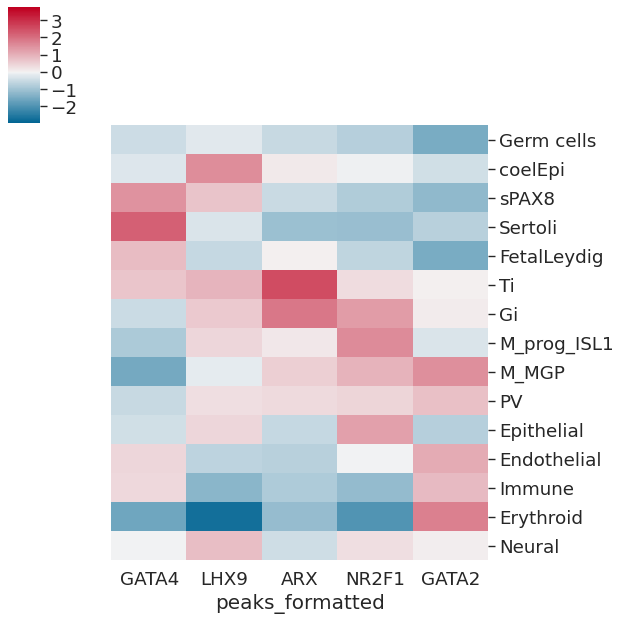

In [39]:
#### Select CCANs to plot 
tfs = [8655, 296, 9615, 7442, 5663]
import seaborn as sns
import matplotlib.pyplot as plt
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.5)
heatmap = sns.clustermap(celltype_CCANs_zscore[tfs], row_cluster=False, col_cluster = False, 
                         annot=False, xticklabels = [ 'GATA4', 'LHX9', 'ARX', 'NR2F1', 'GATA2'], yticklabels = "auto",  
                          figsize=(8, 8),
                         cmap = my_cmap, norm=divnorm)
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_males/heatmap_males_5TFs_ccans.pdf")

/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


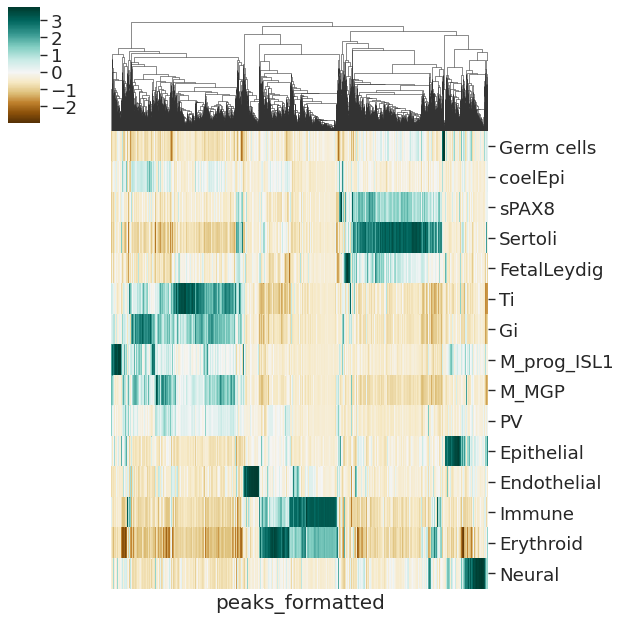

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = "BrBG", norm=divnorm)
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_males/heatmap_males_ccans_green.pdf")

/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


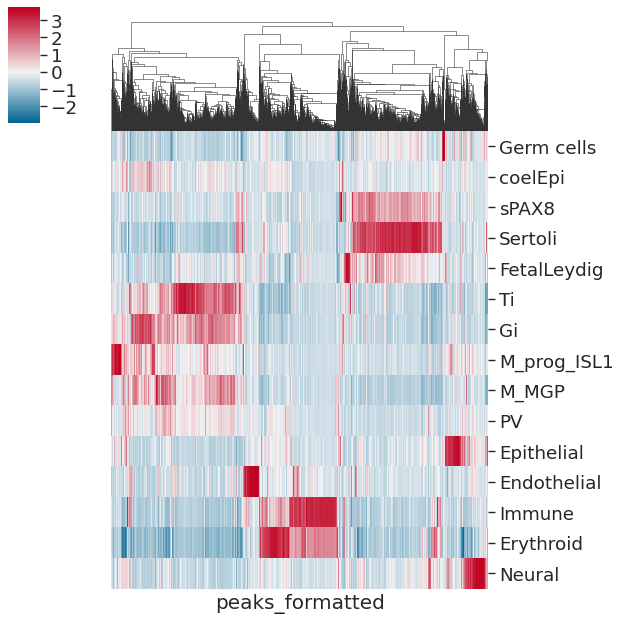

In [41]:
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.5)

heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = my_cmap, norm=divnorm)
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_males/heatmap_males_ccans_red.pdf")

In [42]:
celltype_CCANs_zscore.to_csv(outdir + experiment_prefix + "_zscore_ccans.csv")

### UMAP embedding of CCANs

In [101]:
# Create anndata 
celltype_CCANs_zscore_transposed = celltype_CCANs_zscore.transpose()
ccans_adata = anndata.AnnData(X = celltype_CCANs_zscore_transposed)
ccans_adata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4369 × 15

In [102]:
sc.pp.neighbors(ccans_adata, random_state= 123)
sc.tl.umap(ccans_adata)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


In [103]:
ccans_adata.obs['male_value'] = ccans_adata.X.argmax(axis=1)

In [104]:
ccans_adata.obs['male_value'].value_counts(dropna = False)

2     990
5     658
10    563
13    413
6     348
7     279
14    267
12    227
11    214
8     184
4      89
3      58
0      46
9      22
1      11
Name: male_value, dtype: int64

In [105]:
celltype_CCANs_zscore.index

Index(['Germ cells', 'coelEpi', 'Sertoli', 'sPAX8', 'FetalLeydig', 'Ti', 'Gi',
       'M_MGP', 'M_prog_ISL1', 'PV', 'Immune', 'Endothelial', 'Epithelial',
       'Erythroid', 'Neural'],
      dtype='object')

In [106]:
supporting_cluster = {0 :'Germ cells', 1 : 'coelEpi', 2 : 'Sertoli', 3 : 'sPAX8', 4 : 'FetalLeydig', 5 : 'Ti', 6 : 'Gi',
       7 : 'M_MGP', 8 : 'M_prog_ISL1', 9 : 'PV',10 :  'Immune', 11 : 'Endothelial', 12 : 'Epithelial',
       13 : 'Erythroid', 14 : 'Neural'}
ccans_adata.obs['clusters'] = ccans_adata.obs['male_value'].map(supporting_cluster)
ccans_adata.obs['clusters'].value_counts(dropna = False)

Sertoli        990
Ti             658
Immune         563
Erythroid      413
Gi             348
M_MGP          279
Neural         267
Epithelial     227
Endothelial    214
M_prog_ISL1    184
FetalLeydig     89
sPAX8           58
Germ cells      46
PV              22
coelEpi         11
Name: clusters, dtype: int64

In [107]:
new_palette = ['saddlebrown', 'chocolate','red', 'darkorange', 'gold', 'olivedrab', 'forestgreen',  'limegreen', 
               'navy', 'dodgerblue', 'turquoise', 'paleturquoise',  'blueviolet', 'violet', 'hotpink', 'lightpink', 'slategray', 
              ]

... storing 'clusters' as categorical


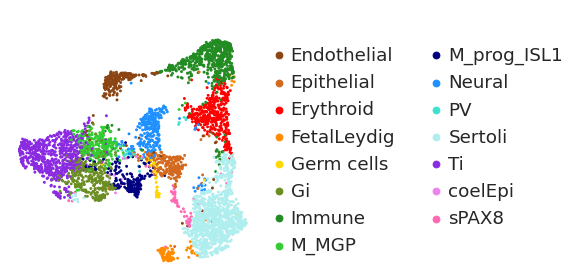

In [108]:
sc.pl.umap(ccans_adata, color = 'clusters',  title = " ", frameon = False,  outline_color = ('black', 'white'),
           palette = new_palette, save = "_ccans_males_full_umap.pdf")

### Plot cell-type specific CCANs

In [129]:
sns.set(rc={'figure.figsize':(5,4), 'figure.facecolor':'black'})
sns.set_context("poster", rc={"axes.labelsize":1})
sns.set(font_scale = 1)

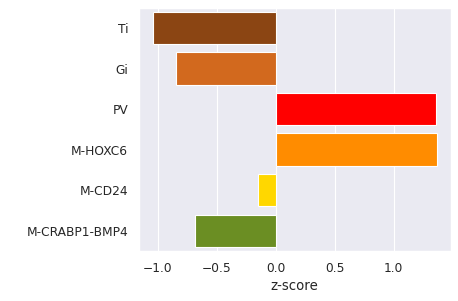

In [130]:
### GATA2 
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[5604], y = celltype_CCANs_zscore.index, 
            palette = new_palette, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_GATA2_CCAN.pdf")

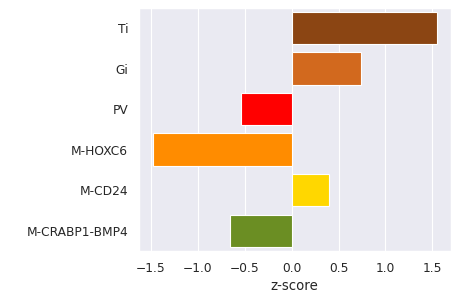

In [131]:
### GATA4 
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[8633], y = celltype_CCANs_zscore.index, 
            palette = new_palette, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_GATA4_CCAN.pdf")

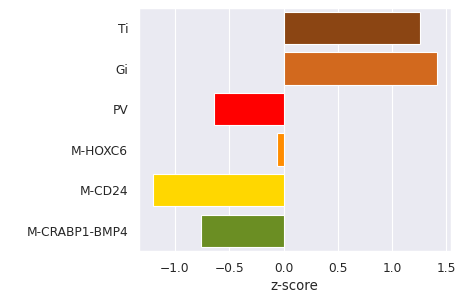

In [132]:
### ARX 
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[9589], y = celltype_CCANs_zscore.index, 
            palette = new_palette, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_ARX_CCAN.pdf")

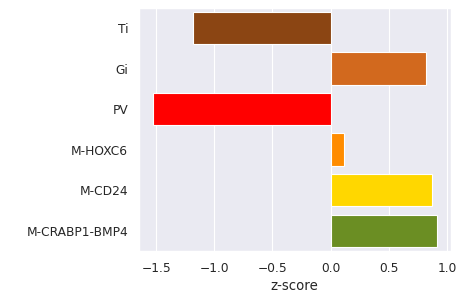

In [133]:
### NRF2 
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[7415], y = celltype_CCANs_zscore.index, 
            palette = new_palette, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_N2RF1_CCAN.pdf")

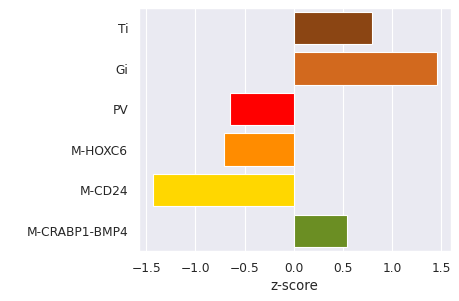

In [134]:
### LHX9 
pcos_barplot = sns.barplot(x = celltype_CCANs_zscore[277], y = celltype_CCANs_zscore.index, 
            palette = new_palette, saturation = 1)
                           
pcos_barplot.set(xlabel='z-score', ylabel=' ')
pcos_barplot.figure.savefig("_LHX9_CCAN.pdf")

## Save peaks files as BED files

In [60]:
# Make a dictionary mapping cell type to set of CCANs enriched in that cell type  
cell_ccan_mapping = ccans_adata.obs.groupby('clusters').groups
#cell_ccan_mapping

In [61]:
peaks_mapping[1]

Index(['chr1-100048203-100049136', 'chr1-100127012-100127812',
       'chr1-100132297-100133517', 'chr1-100249070-100250281',
       'chr1-100265520-100266895', 'chr1-100354904-100355235',
       'chr1-100364322-100365277', 'chr1-99766035-99766825',
       'chr1-99879389-99880074', 'chr1-99969279-99970665'],
      dtype='object', name='peaks_formatted')

In [62]:
# Create a list of lists containing the peaks associated to each cell type
cell_types = ['Endothelial', 'Epithelial', 'Erythroid', 'FetalLeydig', 'Germ cells',
       'Gi', 'Immune', 'M-CD24', 'M-CRABP1-BMP4', 'M-HOXC6', 'Neural', 'PV',
       'Sertoli-NR4A1', 'Ti', 'coelEpi', 'sLGR5/sKITLG', 'sPAX8']
big_list = []
for cell_type in cell_types: 
    ccan_list = list(cell_ccan_mapping[cell_type])
    cell_type_peaks = []
    for ccan in ccan_list: 
        ccan_int = int(ccan)
        ccan_peaks = list(peaks_mapping[ccan_int])
        cell_type_peaks.extend(ccan_peaks)
    print("{}: {} associated CCANs --> {} peaks".format(cell_type, len(ccan_list), 
                                                                                  len(cell_type_peaks)))
    big_list.append(cell_type_peaks)

Endothelial: 187 associated CCANs --> 1618 peaks
Epithelial: 88 associated CCANs --> 488 peaks
Erythroid: 645 associated CCANs --> 17243 peaks
FetalLeydig: 70 associated CCANs --> 278 peaks
Germ cells: 37 associated CCANs --> 166 peaks
Gi: 345 associated CCANs --> 5782 peaks
Immune: 456 associated CCANs --> 5650 peaks
M-CD24: 200 associated CCANs --> 1186 peaks
M-CRABP1-BMP4: 191 associated CCANs --> 1240 peaks
M-HOXC6: 281 associated CCANs --> 4098 peaks
Neural: 355 associated CCANs --> 3373 peaks
PV: 7 associated CCANs --> 30 peaks
Sertoli-NR4A1: 1024 associated CCANs --> 15801 peaks
Ti: 680 associated CCANs --> 11404 peaks
coelEpi: 5 associated CCANs --> 16 peaks
sLGR5/sKITLG: 46 associated CCANs --> 210 peaks
sPAX8: 47 associated CCANs --> 173 peaks


In [63]:
# Remove peaks belonging to sex chromosomes X and Y 
big_list_somatic = []
for sublist in big_list: 
    sublist_somatic = [i for i in sublist if "X" not in i and "Y" not in i]
    big_list_somatic.append(sublist_somatic)

In [64]:
# Create a dataframe for each cell type containing chrom, chromStart, chromEnd for each peak 
bed_df_list = []
for sublist_somatic in big_list_somatic: 
    chrom = [i.split("-")[0] for i in sublist_somatic] # need to remove chr prefix
    chromStart = [int(i.split("-")[1]) for i in sublist_somatic]
    chromEnd = [int(i.split("-")[2]) for i in sublist_somatic]
    bed_dict = {'chrom' : chrom, 'chromStart' : chromStart, 'chromEnd' : chromEnd}
    bed_df = pd.DataFrame(bed_dict)
    #bed_df = bed_df.set_index('chrom')
    bed_df_list.append(bed_df)

In [65]:
len(bed_df_list)

17

In [66]:
import pybedtools

In [67]:
for idx in range(17):
    cell_type = cell_types[idx]
    print(cell_type)
    bed_df = bed_df_list[idx]
    if cell_type == "sLGR5/sKITLG":
        pybedtools.BedTool.from_dataframe(bed_df, 
            outfile = "/nfs/team292/vl6/my_MULTIOME_dir/males_feb2021/beds_full/" + "sLGR5_sKITLG" + ".bed", 
                                     index=False, sep='\t')
    elif cell_type == "Germ cells":
         pybedtools.BedTool.from_dataframe(bed_df, 
            outfile = "/nfs/team292/vl6/my_MULTIOME_dir/males_feb2021/beds_full/" + "GermCells" + ".bed", 
                                     index=False, sep='\t')
    else:
        pybedtools.BedTool.from_dataframe(bed_df, 
                outfile = "/nfs/team292/vl6/my_MULTIOME_dir/males_feb2021/beds_full/" + cell_type + ".bed", 
                                     index=False, sep='\t')

Endothelial
Epithelial
Erythroid
FetalLeydig
Germ cells
Gi
Immune
M-CD24
M-CRABP1-BMP4
M-HOXC6
Neural
PV
Sertoli-NR4A1
Ti
coelEpi
sLGR5/sKITLG
sPAX8


#### End of notebook